In [24]:
import pandas as pd
import numpy as np
import datetime
from time import strftime
import calendar

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [25]:
! pip install livelossplot

In [26]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    classes = np.arange(len(model.classes_))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [27]:
from sklearn.metrics import classification_report, plot_roc_curve

def print_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.plot([(0,0),(1,1)], '--y')
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

# Data cleaning

In [28]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

# Model Building

## Encoding

In [29]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [30]:
df_t = pd.DataFrame()

le = LabelEncoder()
df_t['Gender'] = pd.Series(le.fit_transform(df['Gender']), index=df.index)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df_t['ScheduledDay'] = df['ScheduledDay'].dt.weekday
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')
df_t['AppointmentDay'] = df['AppointmentDay'].dt.weekday
df_t['wait_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df_t['Scholarship'] = df['Scholarship']
df_t['Hypertension'] = df['Hypertension']
df_t['Diabetes'] = df['Diabetes']
df_t['Alcoholism'] = df['Alcoholism']
df_t['Handicap'] = df['Handicap']
df_t['SMSReceived'] = df['SMSReceived']

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(df['Neighbourhood'].to_numpy().reshape(-1,1))
enc_arr = enc.transform(df['Neighbourhood'].to_numpy().reshape(-1,1)).toarray()
Neighbourhoods = enc.get_feature_names()
df_Neighbourhoods = pd.DataFrame(data=enc_arr, columns=enc.get_feature_names(),
                                 index=df.index)

df_t = pd.concat([df_t, df_Neighbourhoods], axis=1)

le = LabelEncoder()
df_t['NoShow'] = le.fit_transform(df['NoShow'])

df_t[df_t.isnull().any(axis=1)]

,Gender,ScheduledDay,AppointmentDay,wait_time,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,x0_AEROPORTO,x0_ANDORINHAS,x0_ANTÔNIO HONÓRIO,x0_ARIOVALDO FAVALESSA,x0_BARRO VERMELHO,x0_BELA VISTA,x0_BENTO FERREIRA,x0_BOA VISTA,x0_BONFIM,x0_CARATOÍRA,x0_CENTRO,x0_COMDUSA,x0_CONQUISTA,x0_CONSOLAÇÃO,x0_CRUZAMENTO,x0_DA PENHA,x0_DE LOURDES,x0_DO CABRAL,x0_DO MOSCOSO,x0_DO QUADRO,x0_ENSEADA DO SUÁ,x0_ESTRELINHA,x0_FONTE GRANDE,x0_FORTE SÃO JOÃO,x0_FRADINHOS,x0_GOIABEIRAS,x0_GRANDE VITÓRIA,x0_GURIGICA,x0_HORTO,x0_ILHA DAS CAIEIRAS,...,x0_JUCUTUQUARA,x0_MARIA ORTIZ,x0_MARUÍPE,x0_MATA DA PRAIA,x0_MONTE BELO,x0_MORADA DE CAMBURI,x0_MÁRIO CYPRESTE,x0_NAZARETH,x0_NOVA PALESTINA,x0_PARQUE INDUSTRIAL,x0_PARQUE MOSCOSO,x0_PIEDADE,x0_PONTAL DE CAMBURI,x0_PRAIA DO CANTO,x0_PRAIA DO SUÁ,x0_REDENÇÃO,x0_REPÚBLICA,x0_RESISTÊNCIA,x0_ROMÃO,x0_SANTA CECÍLIA,x0_SANTA CLARA,x0_SANTA HELENA,x0_SANTA LUÍZA,x0_SANTA LÚCIA,x0_SANTA MARTHA,x0_SANTA TEREZA,x0_SANTO ANDRÉ,x0_SANTO ANTÔNIO,x0_SANTOS DUMONT,x0_SANTOS REIS,x0_SEGURANÇA DO LAR,x0_SOLON BORGES,x0_SÃO BENEDITO,x0_SÃO CRISTÓVÃO,x0_SÃO JOSÉ,x0_SÃO PEDRO,x0_TABUAZEIRO,x0_UNIVERSITÁRIO,x0_VILA RUBIM,NoShow


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [35]:

for feature in df_t.columns:
    df_t[feature] = df_t[feature].astype('int')

df_t.head()

,Gender,ScheduledDay,AppointmentDay,wait_time,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,x0_AEROPORTO,x0_ANDORINHAS,x0_ANTÔNIO HONÓRIO,x0_ARIOVALDO FAVALESSA,x0_BARRO VERMELHO,x0_BELA VISTA,x0_BENTO FERREIRA,x0_BOA VISTA,x0_BONFIM,x0_CARATOÍRA,x0_CENTRO,x0_COMDUSA,x0_CONQUISTA,x0_CONSOLAÇÃO,x0_CRUZAMENTO,x0_DA PENHA,x0_DE LOURDES,x0_DO CABRAL,x0_DO MOSCOSO,x0_DO QUADRO,x0_ENSEADA DO SUÁ,x0_ESTRELINHA,x0_FONTE GRANDE,x0_FORTE SÃO JOÃO,x0_FRADINHOS,x0_GOIABEIRAS,x0_GRANDE VITÓRIA,x0_GURIGICA,x0_HORTO,x0_ILHA DAS CAIEIRAS,...,x0_JUCUTUQUARA,x0_MARIA ORTIZ,x0_MARUÍPE,x0_MATA DA PRAIA,x0_MONTE BELO,x0_MORADA DE CAMBURI,x0_MÁRIO CYPRESTE,x0_NAZARETH,x0_NOVA PALESTINA,x0_PARQUE INDUSTRIAL,x0_PARQUE MOSCOSO,x0_PIEDADE,x0_PONTAL DE CAMBURI,x0_PRAIA DO CANTO,x0_PRAIA DO SUÁ,x0_REDENÇÃO,x0_REPÚBLICA,x0_RESISTÊNCIA,x0_ROMÃO,x0_SANTA CECÍLIA,x0_SANTA CLARA,x0_SANTA HELENA,x0_SANTA LUÍZA,x0_SANTA LÚCIA,x0_SANTA MARTHA,x0_SANTA TEREZA,x0_SANTO ANDRÉ,x0_SANTO ANTÔNIO,x0_SANTOS DUMONT,x0_SANTOS REIS,x0_SEGURANÇA DO LAR,x0_SOLON BORGES,x0_SÃO BENEDITO,x0_SÃO CRISTÓVÃO,x0_SÃO JOSÉ,x0_SÃO PEDRO,x0_TABUAZEIRO,x0_UNIVERSITÁRIO,x0_VILA RUBIM,NoShow
0,0,4,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,4,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
scaler = MinMaxScaler()
df_t = pd.DataFrame(scaler.fit_transform(df_t), columns=df_t.columns)

df_t.describe()

,Gender,ScheduledDay,AppointmentDay,wait_time,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,x0_AEROPORTO,x0_ANDORINHAS,x0_ANTÔNIO HONÓRIO,x0_ARIOVALDO FAVALESSA,x0_BARRO VERMELHO,x0_BELA VISTA,x0_BENTO FERREIRA,x0_BOA VISTA,x0_BONFIM,x0_CARATOÍRA,x0_CENTRO,x0_COMDUSA,x0_CONQUISTA,x0_CONSOLAÇÃO,x0_CRUZAMENTO,x0_DA PENHA,x0_DE LOURDES,x0_DO CABRAL,x0_DO MOSCOSO,x0_DO QUADRO,x0_ENSEADA DO SUÁ,x0_ESTRELINHA,x0_FONTE GRANDE,x0_FORTE SÃO JOÃO,x0_FRADINHOS,x0_GOIABEIRAS,x0_GRANDE VITÓRIA,x0_GURIGICA,x0_HORTO,x0_ILHA DAS CAIEIRAS,...,x0_JUCUTUQUARA,x0_MARIA ORTIZ,x0_MARUÍPE,x0_MATA DA PRAIA,x0_MONTE BELO,x0_MORADA DE CAMBURI,x0_MÁRIO CYPRESTE,x0_NAZARETH,x0_NOVA PALESTINA,x0_PARQUE INDUSTRIAL,x0_PARQUE MOSCOSO,x0_PIEDADE,x0_PONTAL DE CAMBURI,x0_PRAIA DO CANTO,x0_PRAIA DO SUÁ,x0_REDENÇÃO,x0_REPÚBLICA,x0_RESISTÊNCIA,x0_ROMÃO,x0_SANTA CECÍLIA,x0_SANTA CLARA,x0_SANTA HELENA,x0_SANTA LUÍZA,x0_SANTA LÚCIA,x0_SANTA MARTHA,x0_SANTA TEREZA,x0_SANTO ANDRÉ,x0_SANTO ANTÔNIO,x0_SANTOS DUMONT,x0_SANTOS REIS,x0_SEGURANÇA DO LAR,x0_SOLON BORGES,x0_SÃO BENEDITO,x0_SÃO CRISTÓVÃO,x0_SÃO JOSÉ,x0_SÃO PEDRO,x0_TABUAZEIRO,x0_UNIVERSITÁRIO,x0_VILA RUBIM,NoShow
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.00000,110527.000000,110527.000000,110527.000000,110527.00000,110527.000000,110527.000000,110527.00000,...,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,0.370391,0.371649,0.087479,0.098266,0.197246,0.071865,0.030400,0.005562,0.321026,0.000072,0.020466,0.002452,0.002551,0.003827,0.017254,0.007763,0.002823,0.025089,0.023207,0.030165,0.002805,0.007681,0.012449,0.012648,0.020058,0.002760,0.005067,0.003737,0.007681,0.002126,0.004868,0.00617,0.017091,0.002334,0.006333,0.00969,0.018258,0.001583,0.00969,...,0.006279,0.052521,0.017208,0.005827,0.007455,0.000869,0.003357,0.001221,0.020484,0.000009,0.007256,0.004089,0.000624,0.009364,0.011653,0.014051,0.007555,0.040090,0.020040,0.004053,0.004578,0.001610,0.003872,0.003963,0.028328,0.012051,0.023261,0.024845,0.011545,0.004949,0.001312,0.004243,0.013019,0.016611,0.017887,0.022148,0.028337,0.001375,0.007699,0.201933
std,0.476979,0.275704,0.274334,0.082459,0.297675,0.397921,0.258265,0.171686,0.040386,0.466873,0.008507,0.141587,0.049456,0.050447,0.061746,0.130216,0.087765,0.053056,0.156396,0.150561,0.171041,0.052886,0.087307,0.110881,0.111753,0.140201,0.052459,0.071000,0.061014,0.087307,0.046062,0.069598,0.07831,0.129611,0.048258,0.079330,0.09796,0.133883,0.039760,0.09796,...,0.078991,0.223076,0.130048,0.076110,0.086021,0.029459,0.057840,0.034928,0.141648,0.003008,0.084874,0.063819,0.024978,0.096315,0.107320,0.117701,0.086589,0.196171,0.140139,0.063537,0.067507,0.040098,0.062108,0.062826,0.165909,0.109116,0.150733,0.155652,0.106825,0.070175,0.036197,0.065003,0.113358,0.127811,0.132541,0.147167,0.165934,0.037059,0.087409,0.401444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [33]:
pd.DataFrame(X_t, columns=X.columns).describe().loc[['min','max']]

,Gender,ScheduledDay,AppointmentDay,wait_time,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,x0_AEROPORTO,x0_ANDORINHAS,x0_ANTÔNIO HONÓRIO,x0_ARIOVALDO FAVALESSA,x0_BARRO VERMELHO,x0_BELA VISTA,x0_BENTO FERREIRA,x0_BOA VISTA,x0_BONFIM,x0_CARATOÍRA,x0_CENTRO,x0_COMDUSA,x0_CONQUISTA,x0_CONSOLAÇÃO,x0_CRUZAMENTO,x0_DA PENHA,x0_DE LOURDES,x0_DO CABRAL,x0_DO MOSCOSO,x0_DO QUADRO,x0_ENSEADA DO SUÁ,x0_ESTRELINHA,x0_FONTE GRANDE,x0_FORTE SÃO JOÃO,x0_FRADINHOS,x0_GOIABEIRAS,x0_GRANDE VITÓRIA,x0_GURIGICA,x0_HORTO,x0_ILHA DAS CAIEIRAS,...,x0_JOANA D´ARC,x0_JUCUTUQUARA,x0_MARIA ORTIZ,x0_MARUÍPE,x0_MATA DA PRAIA,x0_MONTE BELO,x0_MORADA DE CAMBURI,x0_MÁRIO CYPRESTE,x0_NAZARETH,x0_NOVA PALESTINA,x0_PARQUE INDUSTRIAL,x0_PARQUE MOSCOSO,x0_PIEDADE,x0_PONTAL DE CAMBURI,x0_PRAIA DO CANTO,x0_PRAIA DO SUÁ,x0_REDENÇÃO,x0_REPÚBLICA,x0_RESISTÊNCIA,x0_ROMÃO,x0_SANTA CECÍLIA,x0_SANTA CLARA,x0_SANTA HELENA,x0_SANTA LUÍZA,x0_SANTA LÚCIA,x0_SANTA MARTHA,x0_SANTA TEREZA,x0_SANTO ANDRÉ,x0_SANTO ANTÔNIO,x0_SANTOS DUMONT,x0_SANTOS REIS,x0_SEGURANÇA DO LAR,x0_SOLON BORGES,x0_SÃO BENEDITO,x0_SÃO CRISTÓVÃO,x0_SÃO JOSÉ,x0_SÃO PEDRO,x0_TABUAZEIRO,x0_UNIVERSITÁRIO,x0_VILA RUBIM
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## DNN

18 Input features -- 
1 prediction

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

### Feature pre-prossesing

In [44]:
X = df_t.drop(['NoShow'], axis=1)
y = df_t['NoShow']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.33, random_state=42)

In [52]:
layers = []
layers.append(Dense(64, input_dim=91, activation='relu', name='fc_1')) # 1st fully connected layer
layers.append(Dense(64, activation='relu', name='fc_2')) # 2nd connected layer
layers.append(Dense(1, activation='sigmoid', name='fc_3')) # 3rd fully connected layer
model = Sequential(layers, name='show/no_show')

In [53]:
model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['accuracy'])#, 'AUC'])

In [54]:
print(f'input shape: {model.input_shape[1]}')
print(f'out shape: {model.output_shape[1]}\n\n')


model.summary()

input shape: 91
out shape: 1


Model: "show/no_show"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_1 (Dense)                 (None, 64)                5888      
_________________________________________________________________
fc_2 (Dense)                 (None, 64)                4160      
_________________________________________________________________
fc_3 (Dense)                 (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


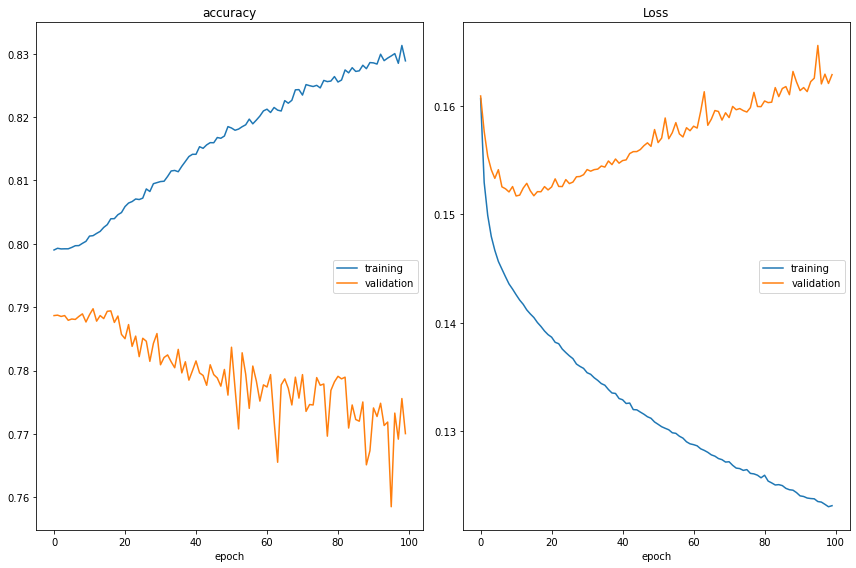

accuracy
	training         	 (min:    0.799, max:    0.831, cur:    0.829)
	validation       	 (min:    0.758, max:    0.790, cur:    0.770)
Loss
	training         	 (min:    0.123, max:    0.161, cur:    0.123)
	validation       	 (min:    0.152, max:    0.166, cur:    0.163)


In [55]:
from livelossplot import PlotLossesKeras

history = model.fit(x=X_train, y=y_train, validation_split=0.2,
                    epochs=100, batch_size=200, verbose=-1,
                    callbacks=[PlotLossesKeras()])

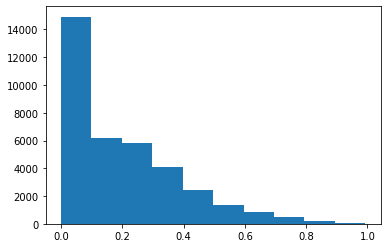

In [57]:
y_pred = model.predict(X_test)
plt.hist(y_pred);

In [59]:
y_pred.mean(), y_test.mean()

(0.19748273, 0.20011515051817733)

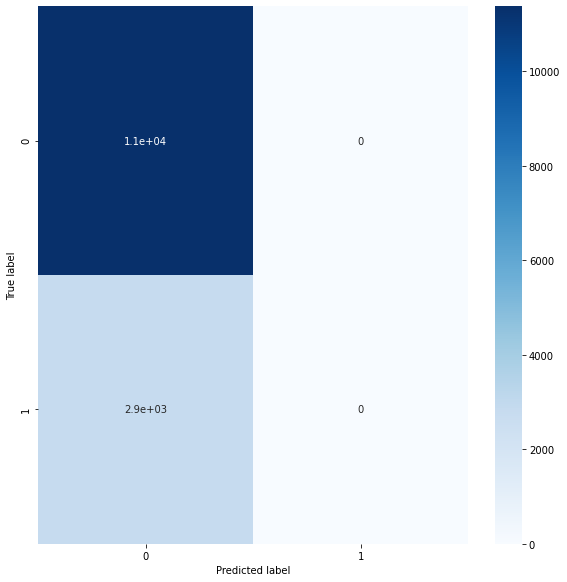

In [ ]:
from tensorflow.math import confusion_matrix 
y_pred=model.predict(X_test)
con_mat = confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_df = pd.DataFrame(con_mat)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()